In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import brentq
import scipy.stats as si
from scipy.stats import norm
import matplotlib.patches as patches
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as patches
API_KEY = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
us_holidays = holidays.US(years=2024)
dst_start = pd.to_datetime('2024-03-10')
dst_end = pd.to_datetime('2024-11-03')
fila =6 # Determina el ancho de la caja en la que buscaremos el máx y el mín.
# no confundir fila que determina la caja del IB con row que determina el núm. de índice cuando la caja es rota.

In [2]:
def get_time_based_on_dst(fecha):
    if dst_start <= fecha <= dst_end:
        return pd.to_datetime('13:30:00').time()
    else:
        return pd.to_datetime('14:30:00').time()

def next_working_day(date, DTE):
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    next_day = date_obj + timedelta(days= DTE)
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    return next_day.strftime('%Y-%m-%d')

def get_stock_price(date, expiration_day):
    url = f"https://api.polygon.io/v2/aggs/ticker/SPY/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #print(url)  # For debugging purposes
    #print(f"Trading Date:    {date}")
    #print(f"Expiration Date: {expiration_day}")
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data:
                return [(result['t'], result['c']) for result in data['results']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return []

def get_stock_data_for_date(date, DTE):
    expiration_day = next_working_day(date, DTE)
    option_data = get_stock_price(date, expiration_day)
    df = pd.DataFrame(option_data, columns=['timestamp', 'stock_price'])
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['time_filter'] = df['fecha'].apply(get_time_based_on_dst)
    df = df[df['fecha'].dt.time >= df['time_filter']]
    df['stock_price'] = round(df['stock_price'],2)
    df = df.reset_index(drop=True)
    df.drop(columns=['time_filter'], inplace=True)
    return df

In [3]:
def get_option_price(ticker, date, expiration_day, option_type):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    print(url)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            # Ensure 'results' key is present in the JSON response
            if 'results' in data:
                results = data['results']
                df_option = pd.DataFrame(results)
                
                # Check what columns are in df_option
                print(df_option.columns)
                
                # Rename columns if they exist
                if all(col in df_option.columns for col in ['o', 'c', 'l', 'h']):
                    df_option = df_option.rename(columns={
                        't': 'timestamp',
                        'o': 'open',
                        'c': 'close',
                        'l': 'low',
                        'h': 'high'
                    })
                    df_option['option_code'] = ticker
                    df_option['option_type'] = option_type                
                    return df_option[['timestamp', 'option_code', 'option_type', 'close']]
                else:
                    print("Expected columns are not present in the returned data.")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [17]:
def plot_option_chart(df_option, strike_B, option_type_B, option_ticker_B, fila, option_type_A, strike_A, option_type_C, strike_C, option_type_D, strike_D):
    ovenight_index = int(len(df_option) / 2) - 40
    end_index = len(df_option) - 2

    df_option['fecha'] = df_option['fecha'].astype(str)
    fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.04})
    ax2 = ax1.twinx()
    ax1.plot(df_option['fecha'], df_option['close_D'], color='magenta', label='D', linewidth=1.4)
    ax1.plot(df_option['fecha'], df_option['close_C'], color='red', label='C', linewidth=2.0)
    ax1.plot(df_option['fecha'], df_option['close_B'], color='green', label='B', linewidth=2.0)
    ax1.plot(df_option['fecha'], df_option['close_A'], color='olive', label='A', linewidth=1.4)
    
    ax2.plot(df_option['fecha'], df_option['stock_price'], color='blue', alpha=1.0, linewidth=0.8)
    ax1.set_ylabel('Prima', color='green')
    ax2.set_ylabel('Stock Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='green')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax1.yaxis.grid(True, alpha=0.6)
    ax1.xaxis.grid(False)
    
    ax1.tick_params(axis='x', which='both', length=0, labelbottom=False)
    
    ax1.axvline(x=fila, color='grey', alpha=0.56, linestyle='-', linewidth=0.7)
    ax1.axvline(x=ovenight_index, color='grey', alpha=0.5, linestyle='-', linewidth=0.7)
    
    ax2.axhline(y=strike_B, color='green', alpha=0.7, linestyle='--')
    ax2.axhline(y=strike_A, color='olive', alpha=0.7, linestyle='--')
    ax2.axhline(y=strike_C, color='red', alpha=0.7, linestyle='--')
    ax2.axhline(y=strike_D, color='magenta', alpha=0.7, linestyle='--')
    
    
    ax2.plot(df_option['fecha'][fila], df_option['stock_price'][fila], 'ko', markersize=9)
    
    ax2.plot(df_option['fecha'][ovenight_index], df_option['stock_price'][ovenight_index], 'ro', markersize=9)
    ax2.plot(df_option['fecha'][end_index], df_option['stock_price'][end_index], 'ro', markersize=9)
    
    ax1.set_title(f'Main: {option_ticker_B} - A){option_type_A}{strike_A}  B){option_type_B}{strike_B} / C){option_type_C}{strike_C}  D){option_type_D}{strike_D}  ')
    
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] >= 0),
                     color='green', alpha=0.5, label=' ')
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] < 0),
                     color='red', alpha=0.5, label=' ')
    ax3.set_ylabel('Beneficio Acumulado')
    ax3.tick_params(axis='y')
    ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment('right')

    ax3.yaxis.grid(True, alpha=0.6)
    ax3.xaxis.grid(False)
    ax1.legend(loc='upper center')

    output_dir = 'chart_oputput_sim'
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'sell_the_swan_{timestamp}.png'
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path)
    plt.show()

In [5]:
def generate_option_ticker(expiration_day_B, option_type_B, strike_B):
    # Convert expiration_day_B to the desired format (YYMMDD without '20' and '-')
    expiration_day_B_formatted = expiration_day_B.strftime('%y%m%d')
    strike_B_formatted = f'{strike_B:05d}'
    option_ticker_B = f'O:SPY{expiration_day_B_formatted}{option_type_B}{strike_B_formatted}000'
    return option_ticker_B

DISEÑO

In [6]:
date = '2024-08-06'

# OPTION A
option_type_A = 'P'
distance_A =    -3
DTE_A =          1

# OPTION B
option_type_B = 'P'
distance_B =    -1
DTE_B =          1

# OPTION C
option_type_C = 'C'
distance_C =     1
DTE_C =          1

# OPTION D
option_type_D = 'C'
distance_D =     3
DTE_D =          1

In [7]:
# OPTION A - elegir vencimiento
df = get_stock_data_for_date(date, DTE_A)
expiration_day_A = next_working_day(date, DTE_A)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_A = pd.to_datetime(expiration_day_A).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_A = current_stock_price + distance_A
option_ticker_A = generate_option_ticker(expiration_day_A, option_type_A, strike_A)
print (option_ticker_A)
df_option_A = get_option_price(option_ticker_A, date, expiration_day_A, option_type_A)
df_option_A.rename(columns={'option_code': 'option_code_A', 'close': 'close_A', 'option_type': 'option_type_A'}, inplace=True)

O:SPY240807P00516000
https://api.polygon.io/v2/aggs/ticker/O:SPY240807P00516000/range/1/minute/2024-08-06/2024-08-07?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n'], dtype='object')


In [8]:
# OPTION B - elegir vencimiento
df = get_stock_data_for_date(date, DTE_B)
expiration_day_B = next_working_day(date, DTE_B)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_B = pd.to_datetime(expiration_day_B).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_B = current_stock_price + distance_B
option_ticker_B = generate_option_ticker(expiration_day_B, option_type_B, strike_B)
print (option_ticker_B)
df_option_B = get_option_price(option_ticker_B, date, expiration_day_B, option_type_B)
df_option_B.rename(columns={'option_code': 'option_code_B', 'close': 'close_B', 'option_type': 'option_type_B'}, inplace=True)

O:SPY240807P00518000
https://api.polygon.io/v2/aggs/ticker/O:SPY240807P00518000/range/1/minute/2024-08-06/2024-08-07?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n'], dtype='object')


In [9]:
# OPTION C - elegir vencimiento
df = get_stock_data_for_date(date, DTE_C)
expiration_day_C = next_working_day(date, DTE_C)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_C = pd.to_datetime(expiration_day_C).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_C = current_stock_price + distance_C
option_ticker_C = generate_option_ticker(expiration_day_C, option_type_C, strike_C)
print (option_ticker_C)
df_option_C = get_option_price(option_ticker_C, date, expiration_day_C, option_type_C)
df_option_C.rename(columns={'option_code': 'option_code_C', 'close': 'close_C', 'option_type': 'option_type_C'}, inplace=True)

O:SPY240807C00520000
https://api.polygon.io/v2/aggs/ticker/O:SPY240807C00520000/range/1/minute/2024-08-06/2024-08-07?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n'], dtype='object')


In [10]:
# OPTION D - elegir vencimiento
df = get_stock_data_for_date(date, DTE_D)
expiration_day_D = next_working_day(date, DTE_D)   # INDICARE AQUÍ LA CALENDAR PARA LA COBERTURA
expiration_day_D = pd.to_datetime(expiration_day_D).date()
current_stock_price = int(df.iloc[fila]['stock_price'])
strike_D = current_stock_price + distance_D
option_ticker_D = generate_option_ticker(expiration_day_D, option_type_D, strike_D)
print (option_ticker_D)
df_option_D = get_option_price(option_ticker_D, date, expiration_day_D, option_type_D)
df_option_D.rename(columns={'option_code': 'option_code_D', 'close': 'close_D', 'option_type': 'option_type_D'}, inplace=True)

O:SPY240807C00522000
https://api.polygon.io/v2/aggs/ticker/O:SPY240807C00522000/range/1/minute/2024-08-06/2024-08-07?adjusted=true&sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF
Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n'], dtype='object')


In [11]:
print('\nOPCION A')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_A}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_A} {distance_A}        {strike_A}')
print(f'DTE                         {DTE_A}\n')
print('OPCION B')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_B}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_B} {distance_B}        {strike_B}')
print(f'DTE                         {DTE_B}\n')
print('OPCION C')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_C}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_C} {distance_C}         {strike_C}')
print(f'DTE                         {DTE_C}\n')
print('OPCION D')
print(f'Fecha entrada      {date}')
print(f'Fecha vencimiento  {expiration_day_D}')
print(f'Precio Subyacente         {current_stock_price}')
print(f'Precio Strike {option_type_D} {distance_D}         {strike_D}')
print(f'DTE                         {DTE_D}\n')


OPCION A
Fecha entrada      2024-08-06
Fecha vencimiento  2024-08-07
Precio Subyacente         519
Precio Strike P -3        516
DTE                         1

OPCION B
Fecha entrada      2024-08-06
Fecha vencimiento  2024-08-07
Precio Subyacente         519
Precio Strike P -1        518
DTE                         1

OPCION C
Fecha entrada      2024-08-06
Fecha vencimiento  2024-08-07
Precio Subyacente         519
Precio Strike C 1         520
DTE                         1

OPCION D
Fecha entrada      2024-08-06
Fecha vencimiento  2024-08-07
Precio Subyacente         519
Precio Strike C 3         522
DTE                         1



MERGE, PROFIT AND PLOT

In [12]:
df_option = pd.merge(df_option_B, df, on='timestamp', how='left')
df_option = pd.merge(df_option, df_option_A,  on='timestamp', how='left')
df_option = pd.merge(df_option, df_option_C,  on='timestamp', how='left')
df_option = pd.merge(df_option, df_option_D,  on='timestamp', how='left')

In [13]:
coste_B = df_option['close_B'].iloc[0]
df_option['cum_return_B'] = coste_B - df_option['close_B']

coste_A = df_option['close_A'].iloc[0]
df_option['cum_return_A'] = df_option['close_A'] - coste_A 

coste_C = df_option['close_C'].iloc[0]
df_option['cum_return_C'] = coste_C - df_option['close_C']

df_option['cum_return'] = df_option['cum_return_B'] + df_option['cum_return_A'] + df_option['cum_return_C']
df_option = df_option.fillna(method='ffill')

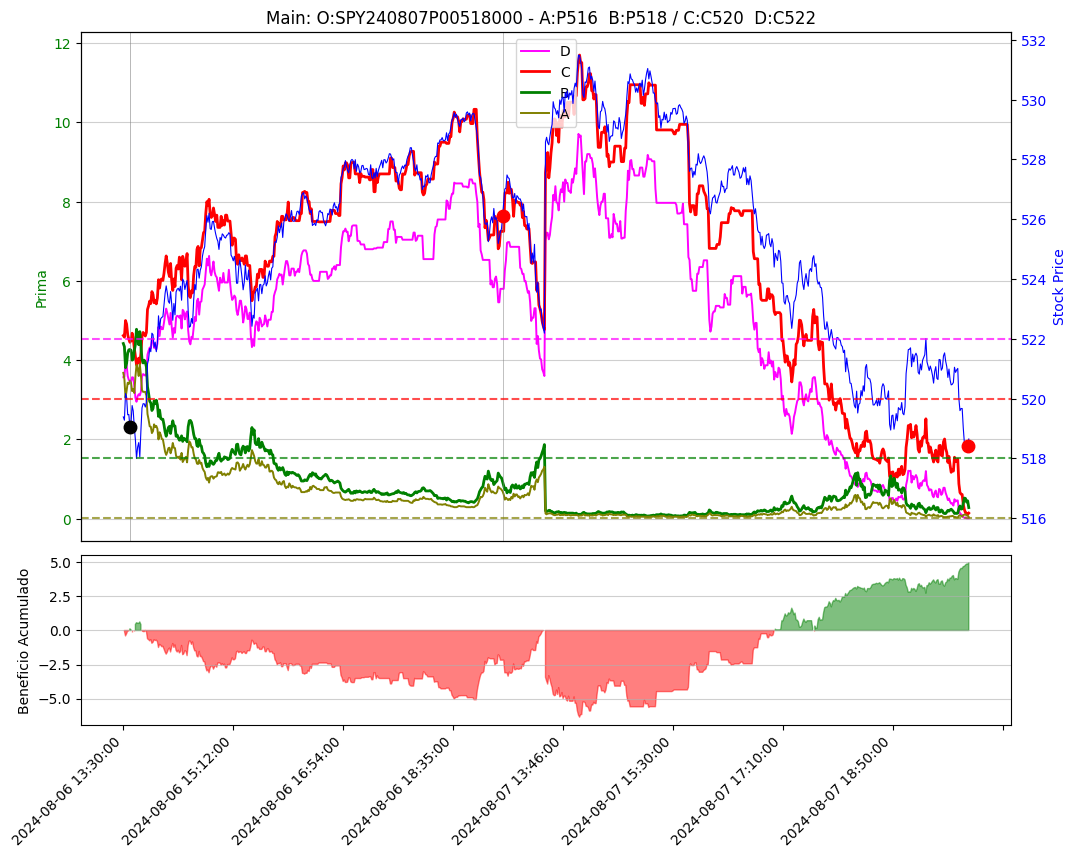

In [14]:
plot_option_chart(df_option, strike_B, option_type_B, option_ticker_B, fila, option_type_A, strike_A, option_type_C, strike_C, option_type_D, strike_D)

In [15]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'options_sim_{timestamp}.csv'
df_option.to_csv(filename, index=False)

In [16]:
df_option

,timestamp,option_code_B,option_type_B,close_B,stock_price,fecha,option_code_A,option_type_A,close_A,option_code_C,option_type_C,close_C,option_code_D,option_type_D,close_D,cum_return_B,cum_return_A,cum_return_C,cum_return
0,1722951000000,O:SPY240807P00518000,P,4.42,519.39,2024-08-06 13:30:00,O:SPY240807P00516000,P,3.68,O:SPY240807C00520000,C,4.62,O:SPY240807C00522000,C,3.57,0.00,0.00,0.00,0.00
1,1722951060000,O:SPY240807P00518000,P,4.34,519.28,2024-08-06 13:31:00,O:SPY240807P00516000,P,3.52,O:SPY240807C00520000,C,4.58,O:SPY240807C00522000,C,3.58,0.08,-0.16,0.04,-0.04
2,1722951120000,O:SPY240807P00518000,P,3.81,520.17,2024-08-06 13:32:00,O:SPY240807P00516000,P,3.05,O:SPY240807C00520000,C,5.00,O:SPY240807C00522000,C,3.93,0.61,-0.63,-0.38,-0.40
3,1722951180000,O:SPY240807P00518000,P,3.92,520.04,2024-08-06 13:33:00,O:SPY240807P00516000,P,3.23,O:SPY240807C00520000,C,4.91,O:SPY240807C00522000,C,3.88,0.50,-0.45,-0.29,-0.24
4,1722951240000,O:SPY240807P00518000,P,4.18,519.46,2024-08-06 13:34:00,O:SPY240807P00516000,P,3.43,O:SPY240807C00520000,C,4.64,O:SPY240807C00522000,C,3.60,0.24,-0.25,-0.02,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,1723060500000,O:SPY240807P00518000,P,0.52,518.52,2024-08-07 19:55:00,O:SPY240807P00516000,P,0.10,O:SPY240807C00520000,C,0.23,O:SPY240807C00522000,C,0.02,3.90,-3.58,4.39,4.71
766,1723060560000,O:SPY240807P00518000,P,0.51,518.40,2024-08-07 19:56:00,O:SPY240807P00516000,P,0.11,O:SPY240807C00520000,C,0.15,O:SPY240807C00522000,C,0.03,3.91,-3.57,4.47,4.81
767,1723060620000,O:SPY240807P00518000,P,0.42,518.47,2024-08-07 19:57:00,O:SPY240807P00516000,P,0.08,O:SPY240807C00520000,C,0.14,O:SPY240807C00522000,C,0.01,4.00,-3.60,4.48,4.88
768,1723060680000,O:SPY240807P00518000,P,0.45,518.40,2024-08-07 19:58:00,O:SPY240807P00516000,P,0.08,O:SPY240807C00520000,C,0.11,O:SPY240807C00522000,C,0.01,3.97,-3.60,4.51,4.88
